# Manual tuning vs. CausalSingleNN SHAP value comparison

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printe
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

In [3]:
module_path = os.path.abspath(os.path.join('..'))
# Relative imports
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from utils.setup import SetupDiagnostics
from neural_networks.load_models import load_models, get_save_plot_folder, load_single_model
from neural_networks.model_diagnostics import ModelDiagnostics
from utils.variable import Variable_Lev_Metadata

In [5]:
from pathlib import Path
import pickle
import datetime
import time
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import itertools
import gc

In [6]:
PROJECT_ROOT = Path.cwd().parent.resolve()

## Get SingleNN and CausalSingleNN SHAP differences

In [7]:
causal_nn_config  = os.path.join(PROJECT_ROOT, "output_castle/eval_nando/causal_single_nn/cfg_causal_single_nn_diagnostics.yml")
causal_nn_shap_path = os.path.join(PROJECT_ROOT, "output_castle/eval_nando/causal_single_nn/plots_offline_evaluation/shap/range-all_samples-1000_all")
causal_nn_map_file = Path(PROJECT_ROOT, "output_castle/eval_nando/single_nn/outputs_map.txt")

single_nn_config = os.path.join(PROJECT_ROOT, "output_castle/eval_nando/single_nn/cfg_single_nn_diagnostics.yml")
single_nn_shap_path = os.path.join(PROJECT_ROOT, "output_castle/eval_nando/single_nn/plots_offline_evaluation/shap/range-all_samples-1000_all",)
single_nn_map_file = Path(PROJECT_ROOT, "output_castle/eval_nando/causal_single_nn/outputs_map.txt")


In [8]:
def parse_txt_to_dict(txt_file):
    line_dict = dict()
    with open(txt_file, 'r') as f:
        for line in f:
            value, key = line.split(":")
            line_dict[key.lstrip().rstrip("\n")] = value.lstrip().rstrip()
    return line_dict

In [9]:
def load_shap_dict(shap_dir, outputs_map):
    print(f"\nLoading SHAP values in {Path(*Path(shap_dir).parts[-4:])}.")
    outputs_varname2save = parse_txt_to_dict(outputs_map)
    outputs_save2varname = {value: key for key, value in outputs_varname2save.items()}
    
    shap_dict_per_var = {}
    for file in glob.glob(str(shap_dir) + "/*.p"):        
        with open(file, "rb") as f:
            d = pickle.load(f)
        var_save_key = re.findall(r"[0-9]_[0-9]+",Path(file).name)[0]
        shap_dict_per_var[Variable_Lev_Metadata.parse_var_name(outputs_save2varname[var_save_key])] = d
    return shap_dict_per_var

In [10]:
def get_setup(setup_file):
    setup = SetupDiagnostics(["-c", setup_file])
    return setup

def generate_input_vars(setup):
    inputs_list = list()
    for spcam_var in setup.spcam_inputs:
        if spcam_var.dimensions == 3:
            for level, _ in setup.parents_idx_levs:
                # There's enough info to build a Variable_Lev_Metadata list
                # However, it could be better to do a bigger reorganization
                var_name = f"{spcam_var.name}-{round(level, 2)}"
                inputs_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
        elif spcam_var.dimensions == 2:
            var_name = spcam_var.name
            inputs_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
    return sorted([p for p in inputs_list], key=lambda x: setup.input_order_list.index(x),)



In [11]:
def get_input2idx_mapping(config, v_name, shap_dict):
    print(f"\nCreating input to index mapping for variable {v_name}.")
    setup = get_setup(config)
    input_vars = generate_input_vars(setup)
    
    var = Variable_Lev_Metadata.parse_var_name(v_name)

    return {input: idx for idx, input in enumerate(shap_dict[var]["inputs"])}

In [12]:
def get_num_inputs(config):
    setup = get_setup(config)
    return len(generate_input_vars(setup))

In [13]:
def get_features(config):
    setup = get_setup(config)
    input_vars = generate_input_vars(setup)

    return [str(v) for v in input_vars]

In [14]:
causal_nn_shap_dict = load_shap_dict(causal_nn_shap_path, causal_nn_map_file)
single_nn_shap_dict = load_shap_dict(single_nn_shap_path, single_nn_map_file)


Loading SHAP values in causal_single_nn/plots_offline_evaluation/shap/range-all_samples-1000_all.

Loading SHAP values in single_nn/plots_offline_evaluation/shap/range-all_samples-1000_all.


In [15]:
var_name = "tphystnd-691.39" # tphystnd-820.86, tphystnd-691.39

In [16]:
causal_nn_input2idx = get_input2idx_mapping(causal_nn_config, var_name, causal_nn_shap_dict)
single_nn_input2idx = get_input2idx_mapping(single_nn_config, var_name, single_nn_shap_dict)

num_inputs = get_num_inputs(single_nn_config)


Creating input to index mapping for variable tphystnd-691.39.

Creating input to index mapping for variable tphystnd-691.39.


In [17]:
# check
var = Variable_Lev_Metadata.parse_var_name(var_name)

causal_nn_input_vars = generate_input_vars(get_setup(causal_nn_config))
single_nn_input_vars = generate_input_vars(get_setup(single_nn_config))

causal_nn_idx2var = {idx: var for idx, var in zip(causal_nn_shap_dict[var]["inputs"], causal_nn_input_vars)}
single_nn_idx2var = {idx: var for idx, var in zip(single_nn_shap_dict[var]["inputs"], single_nn_input_vars)}

for idx in causal_nn_idx2var.keys():
    assert str(causal_nn_idx2var[single_nn_input2idx[idx]]) == str(single_nn_idx2var[causal_nn_input2idx[idx]])

In [18]:
def get_single_causal_shap_diff(metric, v_name):
    metric_key = "shap_values_" + metric
    
    causal_nn_shap_dict = load_shap_dict(causal_nn_shap_path, causal_nn_map_file)
    single_nn_shap_dict = load_shap_dict(single_nn_shap_path, single_nn_map_file)
    
    causal_nn_input2idx = get_input2idx_mapping(causal_nn_config, v_name, causal_nn_shap_dict)
    single_nn_input2idx = get_input2idx_mapping(single_nn_config, v_name, single_nn_shap_dict)

    num_inputs = get_num_inputs(single_nn_config)

    shap_diff_single_causal_nn = np.zeros((num_inputs))
    
    var = Variable_Lev_Metadata.parse_var_name(v_name)

    for i in range(num_inputs):

        try:
            single_nn_shap_value = single_nn_shap_dict[var][metric_key][single_nn_input2idx[i]]
        except KeyError: 
            single_nn_shap_value = 0.

        try: 
            causal_nn_shap_value = causal_nn_shap_dict[var][metric_key][causal_nn_input2idx[i]]
        except KeyError: 
            causal_nn_shap_value = 0.

        shap_diff_single_causal_nn[i] = single_nn_shap_value - causal_nn_shap_value
    return shap_diff_single_causal_nn

## Get SHAP tuning differences

In [19]:
import matplotlib.pyplot as plt
import cmocean
import matplotlib as mpl

In [20]:
def get_shap_diffs(tuning_shap_path, tuning_config, v_name, metric):
    print(f"\nGetting SHAP difference for variable {v_name}.")

    tuning_nn_shap_dict = load_shap_dict(tuning_shap_path, map_file)
    causal_nn_shap_dict = load_shap_dict(causal_nn_shap_path, causal_nn_map_file)
    single_nn_shap_dict = load_shap_dict(single_nn_shap_path, single_nn_map_file)
    
    tuning_nn_input2idx = get_input2idx_mapping(tuning_config, v_name, tuning_nn_shap_dict)
    causal_nn_input2idx = get_input2idx_mapping(causal_nn_config, v_name, causal_nn_shap_dict)
    single_nn_input2idx = get_input2idx_mapping(single_nn_config, v_name, single_nn_shap_dict)
    
    num_inputs = get_num_inputs(single_nn_config)
        
    shap_diff_tuning_causal_nn = np.zeros((num_inputs))
    shap_diff_tuning_single_nn = np.zeros((num_inputs))
    
    metric_key = "shap_values_" + metric
    
    var = Variable_Lev_Metadata.parse_var_name(v_name)
    
    for i in range(num_inputs):
        try: 
            tuning_nn_shap_value = tuning_nn_shap_dict[var][metric_key][tuning_nn_input2idx[i]]
        except KeyError: 
            tuning_nn_shap_value = 0.

        try: 
            causal_nn_shap_value = causal_nn_shap_dict[var][metric_key][causal_nn_input2idx[i]]
        except KeyError: 
            causal_nn_shap_value = 0.

        try: 
            single_nn_shap_value = single_nn_shap_dict[var][metric_key][single_nn_input2idx[i]]
        except KeyError: 
            single_nn_shap_value = 0.

        shap_diff_tuning_causal_nn[i] = tuning_nn_shap_value - causal_nn_shap_value
        shap_diff_tuning_single_nn[i] = tuning_nn_shap_value - single_nn_shap_value
        
    return shap_diff_tuning_causal_nn, shap_diff_tuning_single_nn
    

In [21]:
def get_shap_values(tuning_shap_path, tuning_config, v_name, metric):
    print(f"\nGetting SHAP values for variable {v_name}.")
    tuning_nn_shap_dict = load_shap_dict(tuning_shap_path, map_file)
    causal_nn_shap_dict = load_shap_dict(causal_nn_shap_path, causal_nn_map_file)
    single_nn_shap_dict = load_shap_dict(single_nn_shap_path, single_nn_map_file)
    
    tuning_nn_input2idx = get_input2idx_mapping(tuning_config, v_name, tuning_nn_shap_dict)
    causal_nn_input2idx = get_input2idx_mapping(causal_nn_config, v_name, causal_nn_shap_dict)
    single_nn_input2idx = get_input2idx_mapping(single_nn_config, v_name, single_nn_shap_dict)
    
    num_inputs = get_num_inputs(single_nn_config)
        
    shap_causal_nn = np.zeros((num_inputs))
    shap_single_nn = np.zeros((num_inputs))
    shap_tuning_nn = np.zeros((num_inputs))
    
    metric_key = "shap_values_" + metric
    
    var = Variable_Lev_Metadata.parse_var_name(v_name)
    
    for i in range(num_inputs):
        try: 
            shap_tuning_nn[i] = tuning_nn_shap_dict[var][metric_key][tuning_nn_input2idx[i]]
        except KeyError: 
            pass

        try: 
            shap_causal_nn[i] = causal_nn_shap_dict[var][metric_key][causal_nn_input2idx[i]]
        except KeyError: 
            pass
        
        try: 
            shap_single_nn[i] = single_nn_shap_dict[var][metric_key][single_nn_input2idx[i]]
        except KeyError: 
            pass

    return shap_tuning_nn, shap_causal_nn, shap_single_nn

In [22]:
def plot_shap_diff(shap_diff, input_features, metric, which_diff, v_name, abs_values=True, set_xticks_labels=True, set_xlabel=True, set_title=True, save_path="", max_height=None, min_height=None, p=None, s=None):
    plt.rcParams['text.usetex'] = True
    
    fig, ax = plt.subplots()
    fig.set_figwidth(15)

    shap_blue = '#008bfb'
    cmap = cmocean.cm.thermal
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
    
    if abs_values:
        height_values = np.abs(shap_diff)
    else: 
        height_values = shap_diff
    
    # Save the chart so we can loop through the bars below.
    bars = ax.bar(
        x=range(len(input_features)),
        height=height_values,
        color=cmap(rescale(range(len(input_features)))) # shap_blue,
    )
    
    if set_xticks_labels:
        ax.set_xticks(range(len(input_features)))
        ax.set_xticklabels(input_features, rotation=90, ha='center', va='top')

    
    # Axis formatting.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    ax.tick_params(axis='x', labelsize=8)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)
    
    if max_height is not None and min_height is None:
        ax.set_ylim([0, max_height])

    if max_height is not None and min_height is not None:
        ax.set_ylim([min_height, max_height])

    # Add labels and a title. Note the use of `labelpad` and `pad` to add some
    # extra space between the text and the tick labels.
    abs_str = "Absolute " if abs_values else ""

    if set_xlabel:
        ax.set_xlabel('Input Features', labelpad=15, color='#333333')
    ax.set_ylabel(f'{abs_str}Shap Value Difference', labelpad=15, color='#333333')
    
    if set_title:
        if which_diff == 'tuning-single':
            if p is not None and s is not None:
                diff_str = f"CASTLEAdapted ($\lambda_p={p}$, $\lambda_s={s}$) - SingleNN"
            else: 
                diff_str = f"CASTLEAdapted - SingleNN"
        elif which_diff == 'tuning-causal':
            if p is not None and s is not None:
                diff_str = f"CASTLEAdapted ($\lambda_p={p}$, $\lambda_s={s}$) - CausalSingleNN"
            else: 
                diff_str = f"CASTLEAdapted - CausalSingleNN"
        elif which_diff == 'single-causal':
            diff_str = f"SingleNN - CausalSingleNN"
        else:
            raise ValueError(f"which_diff={which_diff} not known.")
        
        
        title_text = f'{abs_str}SHAP Value Difference {diff_str} for Variable {v_name}'

        ax.set_title(title_text, pad=15, color='#333333',
                     weight='bold')

    fig.tight_layout()
    
    if save_path != "":            
        if abs_values:
            name = f'abs_{metric}_shap_{which_diff}_diff_{v_name}.png'
        else:
            name = f'{metric}_shap_diff_{which_diff}_{v_name}.png'
        plt.savefig(os.path.join(save_path, name), dpi=200)
        print(f'\nSaving SHAP differences plot {name}')
        plt.close()


In [23]:
def plot_shap_comparison(tuning_shap, causal_shap, single_shap, input_features, metric, v_name, set_xticks_labels=True, set_xlabel=True, set_title=True, save_path="", p=None, s=None):
    plt.rcParams['text.usetex'] = True
    
    fig, ax = plt.subplots()
    fig.set_figwidth(15)

    cmap = cmocean.cm.thermal
    c1 = "#ff9900"
    c2 = "#1c00ff" # 1c00ff, 008bfb
    c3 = "#00da00" # 00da00, ce18ff
    
    rescale = lambda  y: (y - np.min(y)) / (np.max(y) - np.min(y))
    colors = cmap(rescale(range(10))) 
    color_idx = {"CausalSingleNN": -2, "SingleNN": -5, f"CASTLEAdapted ($\lambda_p={p}$, $\lambda_s={s}$)": -9}
    
    width = 0.25  # the width of the bars
    multiplier = 0

    x = np.arange(len(input_features))
    label_bar_value = {"CausalSingleNN": causal_shap, 
                       f"CASTLEAdapted ($\lambda_p={p}$, $\lambda_s={s}$)": tuning_shap, 
                       "SingleNN": single_shap}
    for (label, bar_value) in label_bar_value.items():
        offset = width * multiplier
        bars = ax.bar(x + offset, bar_value, width=width, label=label, color=colors[color_idx[label]])
        multiplier += 1
        
    if set_xticks_labels:
        ax.set_xticks(x + width)
        ax.set_xticklabels(input_features, rotation=90, ha='center', va='top')
    
    # Axis formatting.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    ax.tick_params(axis='x', labelsize=8)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)
    ax.margins(x=0.001)
    
    ax.legend()
    

    # Add labels and a title. Note the use of `labelpad` and `pad` to add some
    # extra space between the text and the tick labels.
    if set_xlabel:
        ax.set_xlabel('Input Features', labelpad=15, color='#333333')
    ax.set_ylabel(f'Absolute SHAP Values', labelpad=15, color='#333333')
    
    if set_title:
        title_text = f'Absolute SHAP Values for CausalSingleNN, CASTLEAdapted ($\lambda_p={p}$, $\lambda_s={s}$), SingleNN for Variable {v_name}'

        ax.set_title(title_text, pad=15, color='#333333', weight='bold', fontsize=15)

    fig.tight_layout()
    
    if save_path != "":            
        name = f'{metric}_shap_values_comparison_{v_name}.png'

        plt.savefig(os.path.join(save_path, name), dpi=200)
        print(f'\nSaving SHAP comparison plot {name}')
        plt.close()

In [24]:

def run_shap_diff_plots(model_tuned, metric):
    t_init_total = time.time()
    
    shap_diff_single_causal_nn = get_single_causal_shap_diff(metric, var_name)
    abs_max_single_causal = np.max(np.abs(shap_diff_single_causal_nn))
    
    max_single_causal = np.max(shap_diff_single_causal_nn)
    min_single_causal = np.min(shap_diff_single_causal_nn)

    input_features = get_features(single_nn_config)

    
    for p, s in itertools.product(lambda_prediction, lambda_sparsity):
        params_dir = f"lambda_pred_{p}-lambda_sparsity_{s}"

        cfg = os.path.join(base_dir, model_tuned, params_dir, config_name)
        shap_path = os.path.join(base_dir, "evaluation", model_tuned, params_dir, "shap", shap_dir)
        output_path = os.path.join(shap_path, "diff_plots")
        Path(output_path).mkdir(parents=True, exist_ok=True)
        
        print(f"\n\n{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} " + \
              f"--- Plotting SHAP value difference plots for model {model_tuned} for parameters " + \
              f"lambda_prediciton={p}, lambda_sparsity={s}")
        t_init = time.time()
        
        shap_diff_tuning_causal_nn, shap_diff_tuning_single_nn = get_shap_diffs(shap_path, cfg, var_name, metric)
        
        ## Plot differences
        # Plot absolute values
        abs_max_tuning_causal = np.max(np.abs(shap_diff_tuning_causal_nn))
        abs_max_tuning_single = np.max(np.abs(shap_diff_tuning_single_nn))
        abs_max_height = np.max([abs_max_single_causal, abs_max_tuning_causal, abs_max_tuning_single])
        
        plot_shap_diff(shap_diff_tuning_causal_nn, input_features, metric, "tuning-causal", var_name, 
                       abs_values=True, save_path=output_path, max_height=abs_max_height, p=p, s=s)
        plot_shap_diff(shap_diff_tuning_single_nn, input_features, metric, "tuning-single", var_name, 
                       abs_values=True, save_path=output_path, max_height=abs_max_height, p=p, s=s)
        plot_shap_diff(shap_diff_single_causal_nn, input_features, metric, "single-causal", var_name, 
                       abs_values=True, save_path=output_path, max_height=abs_max_height)
        
        # Plot values with sign
        max_tuning_causal = np.max(shap_diff_tuning_causal_nn)
        max_tuning_single = np.max(shap_diff_tuning_single_nn)

        min_tuning_causal = np.min(shap_diff_tuning_causal_nn)
        min_tuning_single = np.min(shap_diff_tuning_single_nn)
        
        max_height = np.max([max_single_causal, max_tuning_causal, max_tuning_single])
        min_height = np.max([min_single_causal, min_tuning_causal, min_tuning_single])
        
        plot_shap_diff(shap_diff_tuning_causal_nn, input_features, metric, "tuning-causal", var_name, 
                       abs_values=False, save_path=output_path, max_height=max_height, min_height=min_height, p=p, s=s)
        plot_shap_diff(shap_diff_tuning_single_nn, input_features, metric, "tuning-single", var_name, 
                       abs_values=False, save_path=output_path, max_height=max_height, min_height=min_height, p=p, s=s)
        plot_shap_diff(shap_diff_single_causal_nn, input_features, metric, "single-causal", var_name, 
                       abs_values=False, save_path=output_path, max_height=max_height, min_height=min_height)
        
        ## Plot absolute values
        shap_tuning_nn, shap_causal_nn, shap_single_nn = get_shap_values(shap_path, cfg, var_name, metric)
        plot_shap_comparison(shap_tuning_nn, shap_causal_nn, shap_single_nn, input_features, metric, var_name, save_path=output_path, p=p, s=s)
        
        t_end = datetime.timedelta(seconds=time.time() - t_init)
        print(f"\n{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} " + \
              f"--- Finished for model {model_tuned} for parameters " + \
              f"lambda_prediction={p}, lambda_sparsity={s}. Elapsed time: {t_end}")
        
        del shap_diff_tuning_causal_nn, shap_diff_tuning_single_nn
        del shap_tuning_nn, shap_causal_nn, shap_single_nn
        gc.collect()
        
    t_end_total = datetime.timedelta(seconds=time.time() - t_init_total)
    print(f"\n\n{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} " + \
          f"--- Finished all SHAP difference plots for {model_tuned}. Total elapsed time: {t_end_total}\n\n") 

In [25]:
# Set tuning parameters
lambda_prediction =[1, 5, 10, 100, 1000] #[1, 2, 4, 8, 10]
lambda_sparsity = [1.0] #[0.1, 0.5, 1.0]

# Set base directory for config files and inputs/outputs list files
var_name = "tphystnd-691.39"  # tphystnd-691.39, tphystnd-820.86

base_dir = os.path.join(PROJECT_ROOT, "output_castle", f"manual_tuning_{var_name.replace('-', '_')}_v5-transposed_l1_entry_scaled_init_he") # manual_tuning_tphystnd_691.39_v3-test2, manual_tuning_tphystnd_820.86_v3
tuning_models = ["castle_adapted_big_notears"]#,
                # "castle_adapted_small_notears", "castle_adapted_small_dagma", "castle_adapted_big_dagma"] 
config_name = "cfg_castle_adapted.yml"
map_file = os.path.join(base_dir,  "outputs_map.txt")



In [26]:
# Shap evaluation paramters
shap_dir = "range-all_samples-1000_all"
metric = "abs_mean"


In [27]:
tunings = [("manual_tuning_tphystnd_691.39_v4-transposed_l1_entry_scaled", "tphystnd-691.39"),
           ("manual_tuning_tphystnd_820.86_v4-transposed_l1_entry_scaled", "tphystnd-820.86")]

for tuning_dir, v in tunings:
    base_dir = os.path.join(PROJECT_ROOT, "output_castle", tuning_dir) 
    var_name = v
    
    t_start = time.time()
    
    print(f"\nBase directory: {base_dir}")
    for m in tuning_models:
        run_shap_diff_plots(m, metric)

    t_finish =  datetime.timedelta(seconds=time.time() - t_start)

    print(f"\n\n{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} " + \
          f"------ Finished. Total elapsed time: {t_finish}\n\n")


Base directory: /work/bd1179/b309247/pycharm_projects/iglesias-suarez2yxx_spuriouslinks/output_castle/manual_tuning_tphystnd_691.39_v4-transposed_l1_entry_scaled

Loading SHAP values in causal_single_nn/plots_offline_evaluation/shap/range-all_samples-1000_all.

Loading SHAP values in single_nn/plots_offline_evaluation/shap/range-all_samples-1000_all.

Creating input to index mapping for variable tphystnd-691.39.

Creating input to index mapping for variable tphystnd-691.39.


2023-12-06 06:52:49 --- Plotting SHAP value difference plots for model castle_adapted_big_notears for parameters lambda_prediciton=1, lambda_sparsity=1.0

Getting SHAP difference for variable tphystnd-691.39.

Loading SHAP values in castle_adapted_big_notears/lambda_pred_1-lambda_sparsity_1.0/shap/range-all_samples-1000_all.

Loading SHAP values in causal_single_nn/plots_offline_evaluation/shap/range-all_samples-1000_all.

Loading SHAP values in single_nn/plots_offline_evaluation/shap/range-all_samples-1000_all.


In [35]:

t_start = time.time()
for m in tuning_models:
    run_shap_diff_plots(m, metric)

t_finish =  datetime.timedelta(seconds=time.time() - t_start)

print(f"\n\n{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} " + \
      f"------ Finished. Total elapsed time: {t_finish}\n\n")


Loading SHAP values in causal_single_nn/plots_offline_evaluation/shap/range-all_samples-1000_all.

Loading SHAP values in single_nn/plots_offline_evaluation/shap/range-all_samples-1000_all.

Creating input to index mapping for variable tphystnd-691.39.

Creating input to index mapping for variable tphystnd-691.39.


2023-11-30 14:15:54 --- Plotting SHAP value difference plots for model castle_adapted_big_notears for parameters lambda_prediciton=1, lambda_sparsity=1.0

Getting SHAP difference for variable tphystnd-691.39.

Loading SHAP values in castle_adapted_big_notears/lambda_pred_1-lambda_sparsity_1.0/shap/range-all_samples-1000_all.

Loading SHAP values in causal_single_nn/plots_offline_evaluation/shap/range-all_samples-1000_all.

Loading SHAP values in single_nn/plots_offline_evaluation/shap/range-all_samples-1000_all.

Creating input to index mapping for variable tphystnd-691.39.

Creating input to index mapping for variable tphystnd-691.39.

Creating input to index mapping for 

## SingleNN - CausalSingleNN Difference

In [25]:
metric = "mean"
var_name = "tphystnd-691.39" # tphystnd-820.86, tphystnd-691.39

In [26]:
shap_diff_single_causal_nn = get_single_causal_shap_diff(metric, var_name)


Loading SHAP values in causal_single_nn/plots_offline_evaluation/shap/range-all_samples-1000_all.

Loading SHAP values in single_nn/plots_offline_evaluation/shap/range-all_samples-1000_all.

Creating input to index mapping for variable tphystnd-691.39.

Creating input to index mapping for variable tphystnd-691.39.


In [27]:
output_path  = Path(PROJECT_ROOT, "output_castle/eval_nando/shap_diffs")
Path(output_path).mkdir(parents=True, exist_ok=True)

input_features = get_features(single_nn_config)

plot_shap_diff(shap_diff_single_causal_nn, input_features, metric, "single-causal", var_name,  abs_values=True, save_path=output_path)
plot_shap_diff(shap_diff_single_causal_nn, input_features, metric, "single-causal", var_name, abs_values=False, save_path=output_path)


Saving SHAP differences plot abs_mean_shap_single-causal_diff_tphystnd-691.39.png

Saving SHAP differences plot mean_shap_diff_single-causal_tphystnd-691.39.png


## For Single Model

In [28]:
p = 1000
s = 1.0
model_tuned = "castle_adapted_big_notears"

In [35]:
params_dir = f"lambda_pred_{p}-lambda_sparsity_{s}"

var_name = "tphystnd-820.86" # tphystnd-820.86, tphystnd-691.39

config_name = "cfg_castle_adapted.yml"

shap_dir = "range-all_samples-1000_all"

base_dir = os.path.join(PROJECT_ROOT, "output_castle", f"manual_tuning_{var_name.replace('-', '_')}_v3") # manual_tuning_tphystnd_691.39_v3-test2, manual_tuning_tphystnd_820.86_v3
cfg = os.path.join(base_dir, model_tuned, params_dir, config_name)
shap_path = os.path.join(base_dir, "evaluation", model_tuned, params_dir, "shap", shap_dir)

map_file = os.path.join(base_dir,  "outputs_map.txt")


In [36]:
metric = "abs_mean"
metric_key = "shap_values_" + metric

In [37]:
shap_diff_single_causal_nn = get_single_causal_shap_diff(metric, var_name)
shap_diff_tuning_causal_nn, shap_diff_tuning_single_nn = get_shap_diffs(shap_path, cfg, var_name, metric)


Loading SHAP values in causal_single_nn/plots_offline_evaluation/shap/range-all_samples-1000_all.

Loading SHAP values in single_nn/plots_offline_evaluation/shap/range-all_samples-1000_all.

Creating input to index mapping for variable tphystnd-820.86.

Creating input to index mapping for variable tphystnd-820.86.

Getting SHAP difference for variable tphystnd-820.86.

Loading SHAP values in castle_adapted_big_notears/lambda_pred_1000-lambda_sparsity_1.0/shap/range-all_samples-1000_all.

Loading SHAP values in causal_single_nn/plots_offline_evaluation/shap/range-all_samples-1000_all.

Loading SHAP values in single_nn/plots_offline_evaluation/shap/range-all_samples-1000_all.

Creating input to index mapping for variable tphystnd-820.86.

Creating input to index mapping for variable tphystnd-820.86.

Creating input to index mapping for variable tphystnd-820.86.


In [38]:
input_features = get_features(single_nn_config)

In [39]:
max_single_causal = np.max(np.abs(shap_diff_single_causal_nn))
max_tuning_causal = np.max(np.abs(shap_diff_tuning_causal_nn))
max_tuning_single = np.max(np.abs(shap_diff_tuning_single_nn))

In [40]:
abs_max_height = np.max([max_single_causal, max_tuning_causal, max_tuning_single])

In [41]:
abs_max_height 

0.04830953424418476

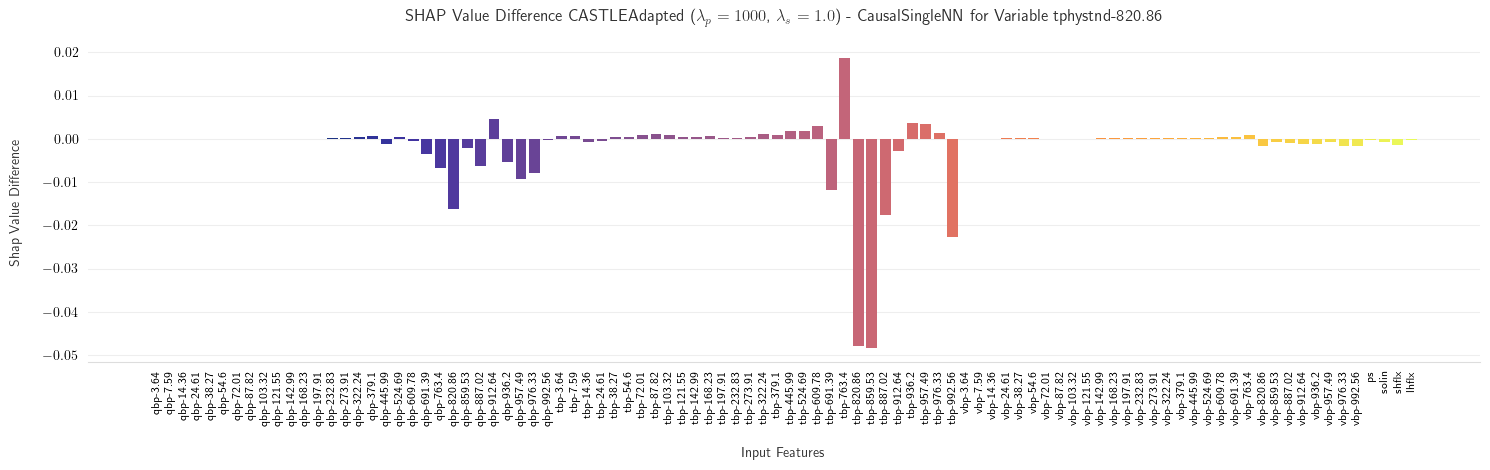

In [42]:
plot_shap_diff(shap_diff_tuning_causal_nn, input_features, metric, "tuning-causal", var_name, abs_values=False, p=p, s=s)

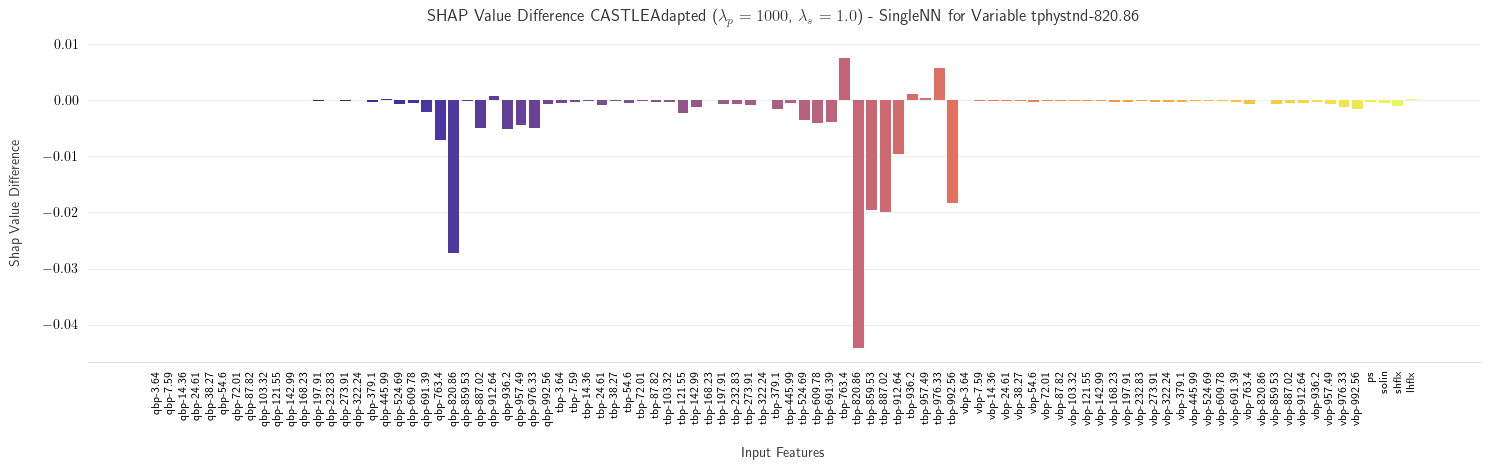

In [43]:
plot_shap_diff(shap_diff_tuning_single_nn, input_features, metric, "tuning-single", var_name, abs_values=False, p=p, s=s)

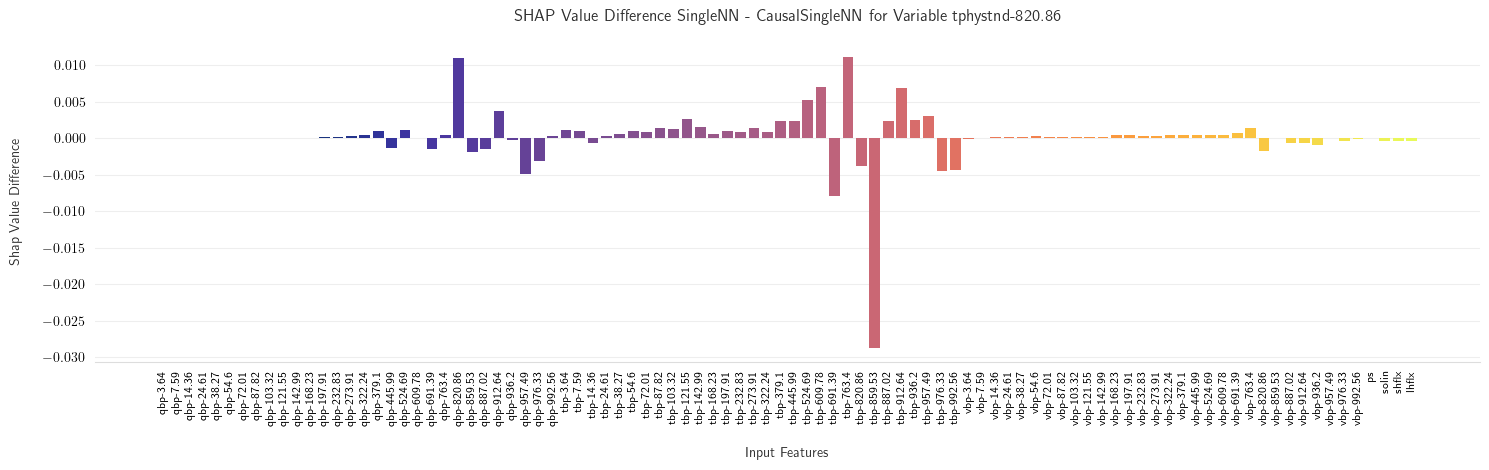

In [44]:
plot_shap_diff(shap_diff_single_causal_nn, input_features, metric, "single-causal", var_name, abs_values=False)

In [45]:
shap_tuning_nn, shap_causal_nn, shap_single_nn = get_shap_values(shap_path, cfg, var_name, metric)
input_features = get_features(single_nn_config)


Getting SHAP values for variable tphystnd-820.86.

Loading SHAP values in castle_adapted_big_notears/lambda_pred_1000-lambda_sparsity_1.0/shap/range-all_samples-1000_all.

Loading SHAP values in causal_single_nn/plots_offline_evaluation/shap/range-all_samples-1000_all.

Loading SHAP values in single_nn/plots_offline_evaluation/shap/range-all_samples-1000_all.

Creating input to index mapping for variable tphystnd-820.86.

Creating input to index mapping for variable tphystnd-820.86.

Creating input to index mapping for variable tphystnd-820.86.


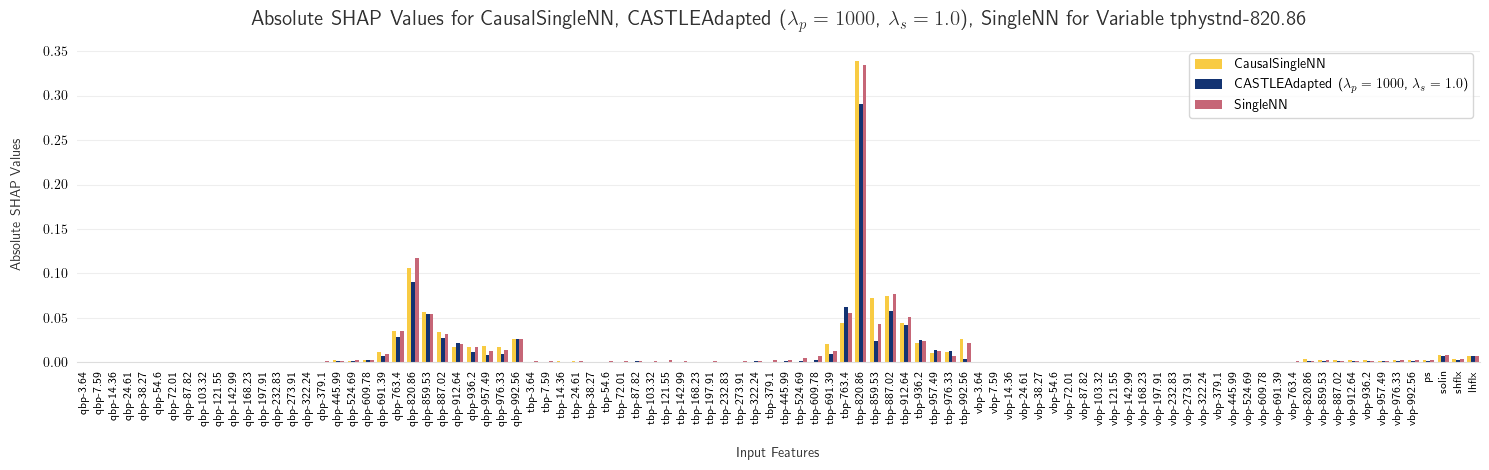

In [52]:
plot_shap_comparison(shap_tuning_nn, shap_causal_nn, shap_single_nn, input_features, metric, var_name, p=p, s=s)